In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats
from scipy.io import loadmat, savemat
from scipy.stats import norm
from scipy.optimize import curve_fit,fmin
from scipy.odr import *

import glob
def calfunc(p,x):
    a,b=p
    return a*x+b
def invcalmodel(y,a,b):
    return (y-b)/a
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def tempvtimerisemodel(p,t):
    tau,T,T_R=p
    #tau=C_p/K_eff
    dt=T-T_R
    
    t2=dt*(np.exp(-t/tau))+T_R
    return t2
def tempvtimefallmodel(p,t):
    tau,T,T_R=p
    #tau=C_p/K_eff
    dt=T-T_R
    
    t2=dt*(np.exp(-t/tau))+T_R
    return t2
    

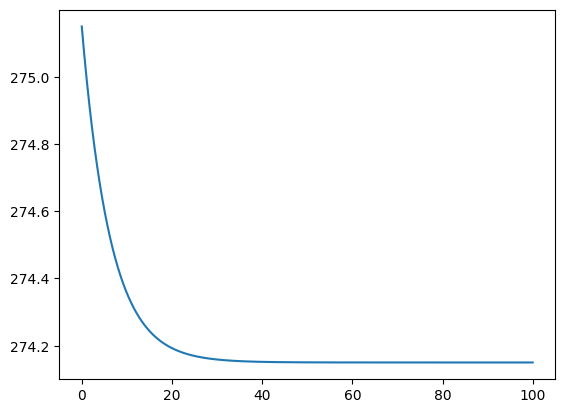

In [85]:
trange=np.arange(0,100,.01)
plt.plot(trange,tempvtimemodel(t=trange,p=[6.34,275.15,274.15]))

Input pulse was a heavside 0 to 5v over 10 s on a 200 ohm resistor'
P= IV=V/R^2=0.125 mW=0.125 mJ/s=> 1.25 mJ

0.02256808404677765


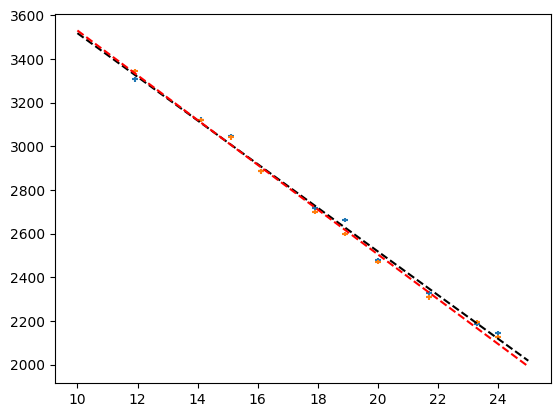

In [10]:
xfine=np.linspace(10,25,1000)
calt= np.array([11.9,14.1,15.1,16.1,17.9,18.9,20,21.7,23.3,24])
calsample=np.array([3306,3122,3048,2888,2715,2661,2480,2326,2188,2144])
calstage=np.array([3345,3120,3040,2885,2699,2598,2469,2308,2196,2127])

#plt.plot(calt,calsample,"k.")
plt.errorbar(calt,calsample,xerr=.1,yerr=10,fmt=" ")
#plt.plot(calt,calstage,"r.")
plt.errorbar(calt,calstage,xerr=.1,yerr=10,fmt=' ')
calmodel=Model(calfunc)
sampledata= RealData(calt,calsample,sx=.1,sy=10)
stagedata=RealData(calt,calstage,sx=.1,sy=10)

sampleodr=ODR(sampledata,calmodel,beta0=[1,1])
stageodr=ODR(stagedata,calmodel,beta0=[1,1])

sampleout=sampleodr.run()
stageout=stageodr.run()


#sampleout.pprint()
#stageout.pprint()
plt.plot(xfine,calfunc(x=xfine,p= sampleout.beta),"--k")
plt.plot(xfine,calfunc(x=xfine,p= stageout.beta),"--r")
calp1=sampleout.beta
temperror=1/np.sqrt(np.sum(sampleout.sd_beta**2))
#plt.plot([10,15,20],[3675,2981,2434],".")
print(temperror)

In [11]:
test7_27=[]
filenames=glob.glob('test8_*.mat')
for i in filenames:
    test7_27.append(loadmat(i))
test7_27[0].keys()


dict_keys(['__header__', '__version__', '__globals__', 'STs', 'Ts', 'pulsetime', 'target', 'ts'])

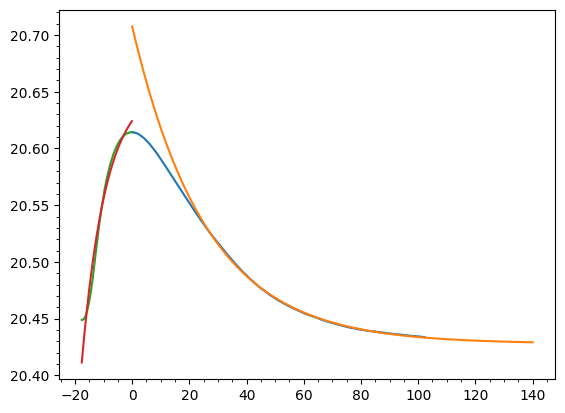

<Figure size 640x480 with 0 Axes>

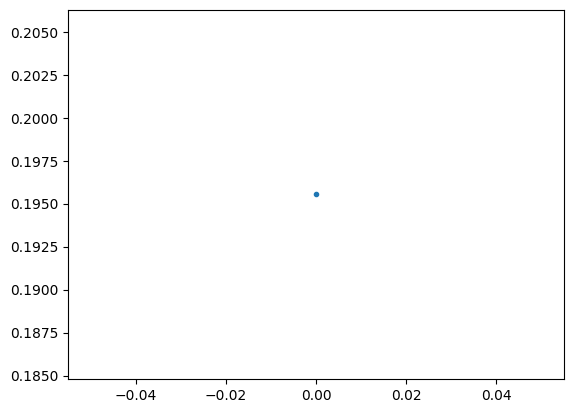

In [203]:
j=1
rplist=[]
rclist=[]
rtaulist=[]

fplist=[]
fclist=[]
ftaulist=[]

plt.figure(0)
modelfall=Model(tempvtimefallmodel)
modelrise=Model(tempvtimerisemodel)
for i in test7_27[j:j+1]:
    
    #some use varbles
    cut=np.where(i['pulsetime'][0][0]==i["ts"][0])[0][0]
    stop=np.where(find_nearest(i["ts"][0],i["ts"][0][cut]+120)==i["ts"][0])[0][0]
    
    maxi=np.where(np.max(invcalmodel(i["STs"][0][cut:stop:],*calp1))==invcalmodel(i["STs"][0][cut:stop:],*calp1))[0][0]
    
    
    
    spline=InterpolatedUnivariateSpline(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],
                  invcalmodel(i["STs"][0][cut+maxi:stop:],*calp1))
    
   
    cut1=cut+np.where(spline(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],nu=1)==
                     np.min(spline(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],nu=1)))[0][0]
    #plt.plot(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi],spline(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi]),".")
    
    
    fdata=RealData(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi],
                  spline(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi]),sy=temperror)
    mint=np.min(invcalmodel(i["STs"][0][cut:cut+maxi:],*calp1))
    maxt=np.max(invcalmodel(i["STs"][0][cut:cut+maxi:],*calp1))
    min1t=np.min(spline(i["ts"][0][cut1+maxi:stop:]-i["ts"][0][cut+maxi]))
    
    plt.plot(i["ts"][0][cut+maxi:stop:]-i["ts"][0][cut+maxi],
                  invcalmodel(i["STs"][0][cut+maxi:stop:],*calp1))
   
    fodr=ODR(fdata,modelfall,beta0=[10,maxt+.05,mint])
    fout=fodr.run()

    plt.plot(i["ts"][0][cut+maxi::]-i["ts"][0][cut+maxi] ,
             tempvtimefallmodel(p=fout.beta,t=i["ts"][0][cut+maxi::]-i["ts"][0][cut+maxi]))
    fplist.append(fout.beta)
    fclist.append(fout.sd_beta)
    ftaulist.append([fout.beta[0],maxt-mint])
    
    #Rise
    rdata=RealData(i["ts"][0][cut:cut+maxi:]-i["ts"][0][cut+maxi],
                  invcalmodel(i["STs"][0][cut:cut+maxi:],*calp1),
                   sy=temperror)
    rodr=ODR(rdata,modelrise,beta0=[10,maxt+.05,mint])
    rout=rodr.run()
    
    
    
    plt.plot(i["ts"][0][cut:cut+maxi:]-i["ts"][0][cut+maxi],
                  invcalmodel(i["STs"][0][cut:cut+maxi:],*calp1))
    
    plt.plot(i["ts"][0][cut:cut+maxi:]-i["ts"][0][cut+maxi] ,
             tempvtimerisemodel(p=rout.beta,t=i["ts"][0][cut:cut+maxi:]-i["ts"][0][cut+maxi]))
    rplist.append(rout.beta)
    rclist.append(rout.sd_beta)
    rtaulist.append([rout.beta[0],maxt-mint])
    
    
    
plt.minorticks_on() 
plt.figure(1)

plt.figure(2)
ftaulist=np.array(ftaulist).T
plt.plot(0.00125*ftaulist[0]/ftaulist[1],".")

#plt.plot(hlist[::][0],plist[::][0],".")

In [177]:
np.array(plist).T[0]

array([30.59801893, 24.93971851, 25.6116904 , 29.8521385 , 33.76293898,
       26.12242147, 25.57180699, 26.24350356, 28.79148137,  8.57684574,
       28.90963414, 29.38087414, 27.78442366, 27.67568089, 10.        ,
       29.61099132, 29.00337073, 28.05088071, 30.88165402, 30.51267601,
       23.94715685, 30.22600184, 24.33985554])

NameError: name 'td' is not defined

(1120.0, 1290.0)

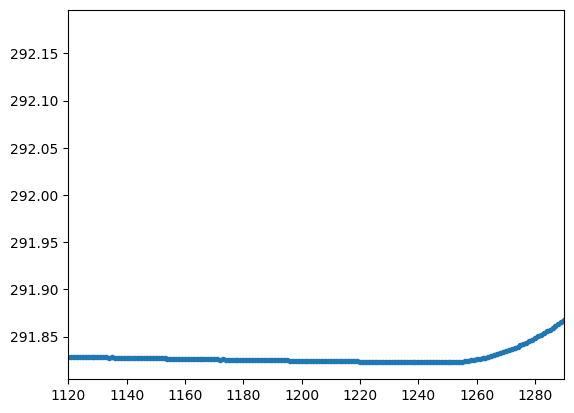

In [593]:
plt.plot(invcalmodel(i["STs"][0][1::],*calp1),".")
plt.xlim(1120,1290)

In [585]:
td["ts"][0][1040]

107.70867549999994

In [586]:
td['pulsetime'][0]

array([122.0374468, 129.3442451,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ])

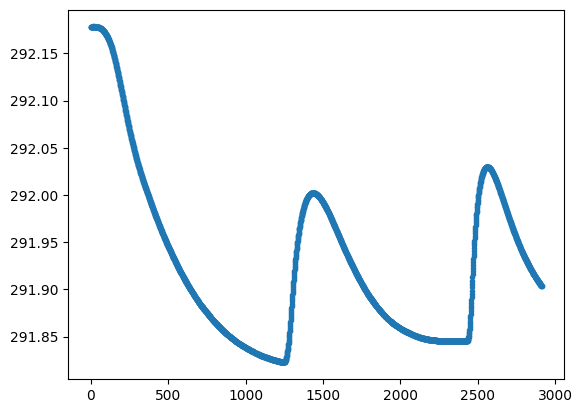

In [592]:
plt.plot(invcalmodel(i["STs"][0][1::],*calp1),".")

In [456]:
td['pulsetime'][0][0]

282.67625300000003

In [455]:
np.where(td['pulsetime'][0][0]==td["ts"][0])[0][0]

2740

In [427]:
find_nearest(i["ts"][0],cut+120)

300.0837551999997